# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2023-2024, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Maria de Neves de Fonseca (M.deNevesdeFonseca-1@student.tudelft.nl)
* (c) TU Delft, 2024

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "timothy van den Heuvel"
STUDENT_1_STUDENT_NUMBER = "5606403"
STUDENT_1_NETID = "timvandenheuve"
STUDENT_1_EMAIL = "t.j.vandenheuvel-1@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions (also after the course is finished), and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for you that you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# Task 3e - Fit an MLP to the forward dynamics and visualize the phase plot (5p)
**Authors:** Giovanni Franzese (G.Franzese@tudelft.nl), Lorenzo Lyons (L.Lyons@tudelft.nl)

In [3]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import random
import pandas as pd
from pathlib import Path
import pickle
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from utils import generate_training_data, process_data, plot_data

# define folder where to save animations and plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)
# define path to folder that contains the datasets
datasets_dir = Path("datasets")

/tmp/ipykernel_13509/3783338513.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Task 3e.1 - Create the Multilayer Perceptron model (0p)
In the following, we define the neural network architecture and create a `Model` class that implements all necessary functionalities for training.

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size).double()
        self.relu1 = nn.ReLU().double()
        self.fc2 = nn.Linear(hidden_size, output_size).double()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

In [5]:
class Model:
    def __init__(self, X, Y, batch_size=256):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.is_cuda = False
        self.model = MLP(self.X.size(1), 1000, self.Y.size(1))
        # to plot the training loss convergence
        self.rmse_loss_vec = np.array([])

    def to_cuda(self):
        if torch.cuda.is_available():
            self.model = self.model.cuda()
            self.X = self.X.cuda()
            self.Y = self.Y.cuda()
            self.is_cuda = True

    def predict(self, X_pred):
        X_pred = X_pred.double()
        if self.is_cuda:
            X_pred = X_pred.cuda()
        return self.model(X_pred)

    def train(self, num_epochs=50):
        self.model = self.model.double()
        self.X = self.X.double()
        self.Y = self.Y.double()
        self.train_dataset = TensorDataset(self.X, self.Y)
        self.train_loader = DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True
        )
        self.model.train()

        optimizer = torch.optim.Adam(
            [
                {"params": self.model.parameters()},
            ],
            lr=0.01,
        )

        # Our loss object. Mean Squared Error
        self.mse = nn.MSELoss()

        # to plot the loss function
        self.rmse_loss_vec = np.zeros(num_epochs)

        for i in tqdm(range(num_epochs)):
            loss_sum = 0.0
            for x_batch, y_batch in self.train_loader:
                optimizer.zero_grad()
                output = self.model(x_batch)
                loss = self.mse(output, y_batch)
                loss.backward()
                optimizer.step()
                loss_sum += loss.detach().cpu()
            self.rmse_loss_vec[i] = (
                torch.sqrt(loss_sum / len(self.train_loader)).detach().item()
            )

    def plot_convergence(self, experiment_name: str):
        # plot loss function
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(self.rmse_loss_vec, label="loss")
        ax.set_xlabel("Epochs")
        ax.set_ylabel(r"Trainings RMSE for $\hat{\ddot{\theta}}$ [rad/s^2]")
        plt.savefig(
            str(outputs_dir / f"task_3e_training_convergence_{experiment_name}.pdf")
        )

    def print_info(self):
        print("Final_error:")
        print(self.mse(self.model(self.X), self.Y))

## Task 3e.2 - Train an MLP on the dataset with large oscillations and visualize the phase portrait (1.5p)
### Task 3e.2.1 - Load the dataset with large oscillations and visualize it (0p)
Load the dataset generated by initializing the double pendulum close to the tip-up configuration (without any external torques applied).

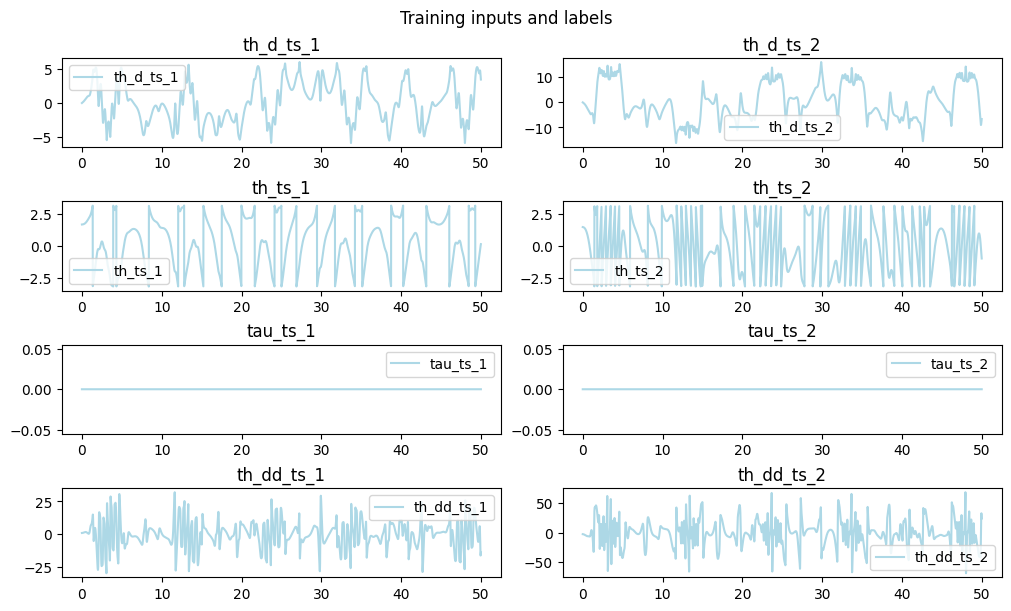

In [6]:
# load the dataset with large oscillations from task 3c
dataset_name_big_osc = "trajectory_zero_gains_big_osc"
df_big_osc = pd.read_csv(datasets_dir / f"{dataset_name_big_osc}.csv")

# indicate input X and Y labels training data
input_columns = ["th_d_ts_1", "th_d_ts_2", "th_ts_1", "th_ts_2", "tau_ts_1", "tau_ts_2"]
output_columns = ["th_dd_ts_1", "th_dd_ts_2"]

# plot the GP training data
plot_data(
    df_big_osc,
    input_columns,
    output_columns,
    filepath=str(outputs_dir / f"task_3e_dataset_plot_{dataset_name_big_osc}.pdf"),
)

# generate torch tensors for training
X_big_osc, Y_big_osc = generate_training_data(df_big_osc, input_columns, output_columns)

### Task 3e.2.2 - Train the MLP (0.5p)
Initialize the MLP and **train it** using the dataset previously loaded.

  0%|          | 0/50 [00:00<?, ?it/s]

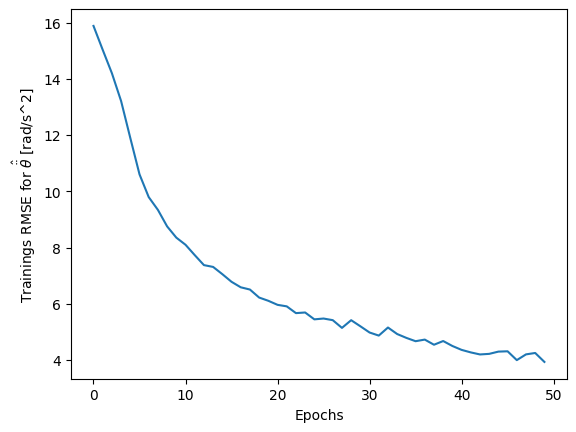

In [7]:
# set torch seed
torch.manual_seed(42)

# forward_model_big_osc =
# YOUR CODE HERE
# Instantiate the model
forward_model_big_osc = Model(X_big_osc, Y_big_osc)
forward_model_big_osc.to_cuda()
forward_model_big_osc.train(num_epochs=50)

# plot convergence of training loss
forward_model_big_osc.plot_convergence(dataset_name_big_osc)

### Task 3e.2.3 - Visualize the learned dynamics with a phase portrait (1p)
For more information about phase portraits, please consult the [Wikipedia article](https://en.wikipedia.org/wiki/Phase_portrait).

Since we cannot visualize the phase portrait of a double pendulum in 2D (it works for a standard pendulum, though), we are going to lock the second DoF by considering the configuration and its velocity equal to the one of the first joint, i.e., no relative movement. We are studying the unforced dynamics of the systems. Hence, the external torques (for both joints) are set to zero. 

In [12]:
theta_dot_min, theta_dot_max = (-8, 8)
# theta_grid, theta_dot_grid =
# Set torques to zero
# tau1 =
# tau2 =
# YOUR CODE HERE
theta_range = np.linspace(-np.pi, np.pi, 100)
theta_dot_range = np.linspace(theta_dot_min, theta_dot_max, 100)
theta_grid, theta_dot_grid = np.meshgrid(theta_range, theta_dot_range)
tau1 = np.zeros_like(theta_grid)
tau2 = np.zeros_like(theta_grid)

# Create input points
input_points = np.column_stack(
    (
        theta_dot_grid.flatten(),
        theta_dot_grid.flatten(),
        theta_grid.flatten(),
        theta_grid.flatten(),
        tau1.flatten(),
        tau2.flatten(),
    )
)

X_test = torch.tensor(input_points, dtype=torch.float32)

##### Perform the predictions for the specified inputs and plot the phase portrait.

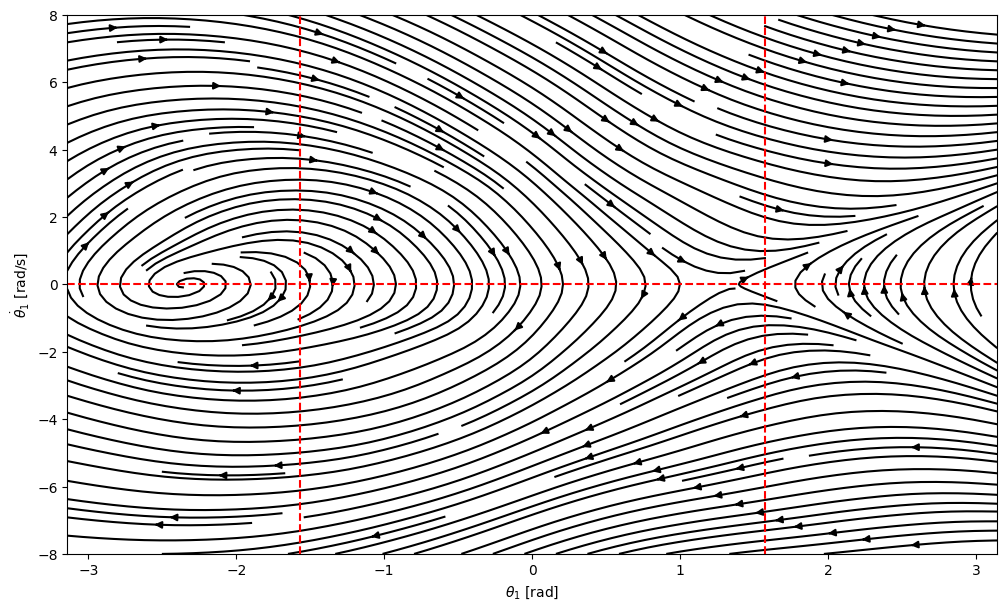

In [13]:
# model prediction
Y_pred_big_osc = forward_model_big_osc.predict(X_test)
Y_pred_mean_grid_big_osc = Y_pred_big_osc[:, 0].detach().cpu().view(100, 100).numpy()

# plot the phase portrait
fig, ax = plt.subplots(figsize=(12, 7))
ax.streamplot(
    theta_grid,
    theta_dot_grid,
    theta_dot_grid,
    Y_pred_mean_grid_big_osc,
    density=2,
    color="black",
)
ax.set_xlabel(r"$\theta_1$ [rad]")
ax.set_ylabel(r"$\dot{\theta}_1$ [rad/s]")
ax.vlines(-np.pi / 2, theta_dot_min, theta_dot_max, color="red", linestyles="dashed")
ax.vlines(np.pi / 2, theta_dot_min, theta_dot_max, color="red", linestyles="dashed")
ax.hlines(0, -np.pi, np.pi, color="red", linestyles="dashed")

## Task 3e.3 - Train an MLP on the dataset with small oscillations and visualize phase portrait (0.5p)
### Task 3e.3.1 - Load the dataset with small oscillations and visualize it (0p)
Load the dataset generated by initializing the double pendulum close to the tip-down configuration (without any external torques applied).

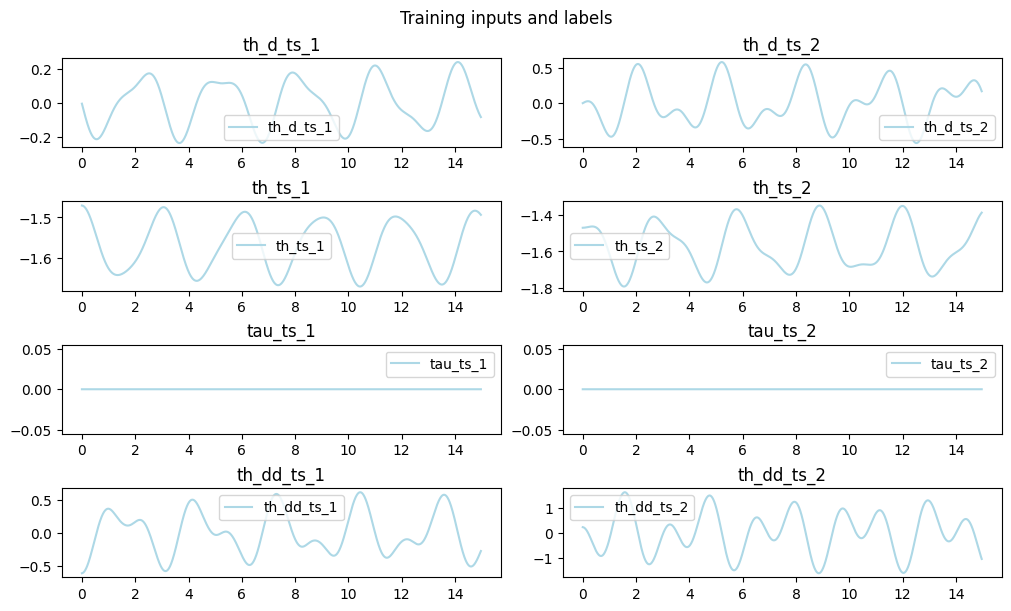

In [14]:
# load the dataset with small oscillations from task 3c
dataset_name_small_osc = "trajectory_zero_gains_small_osc"
df_small_osc = pd.read_csv(datasets_dir / f"{dataset_name_small_osc}.csv")

# indicate input X and Y labels training data
input_columns = ["th_d_ts_1", "th_d_ts_2", "th_ts_1", "th_ts_2", "tau_ts_1", "tau_ts_2"]
output_columns = ["th_dd_ts_1", "th_dd_ts_2"]

# plot the training data
plot_data(
    df_small_osc,
    input_columns,
    output_columns,
    filepath=str(outputs_dir / f"task_3e_dataset_plot_{dataset_name_small_osc}.pdf"),
)

# generate torch tensors for training
X_small_osc, Y_small_osc = generate_training_data(
    df_small_osc, input_columns, output_columns
)

### Task 3e.3.2 - Train the MLP (0.5p)
Initialize the MLP and **train it** using the dataset previously loaded.

  0%|          | 0/50 [00:00<?, ?it/s]

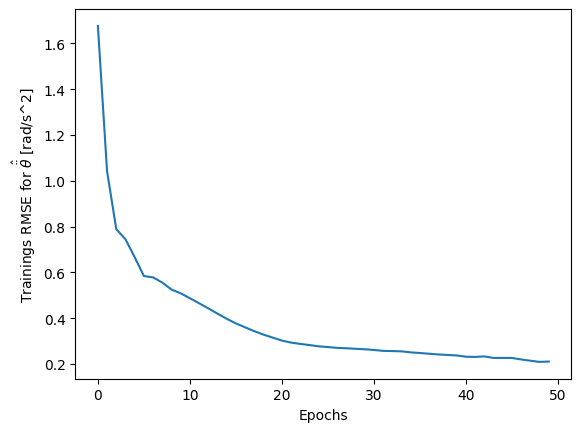

In [15]:
# set torch seed
torch.manual_seed(42)

# forward_model_small_osc =
# YOUR CODE HERE
forward_model_small_osc = Model(X_small_osc, Y_small_osc)
forward_model_small_osc.to_cuda()
forward_model_small_osc.train(num_epochs=50)

# plot convergence of training loss
forward_model_small_osc.plot_convergence(dataset_name_small_osc)

### Task 3e.3.3 - Visualize the learned dynamics with a phase portrait (0p)

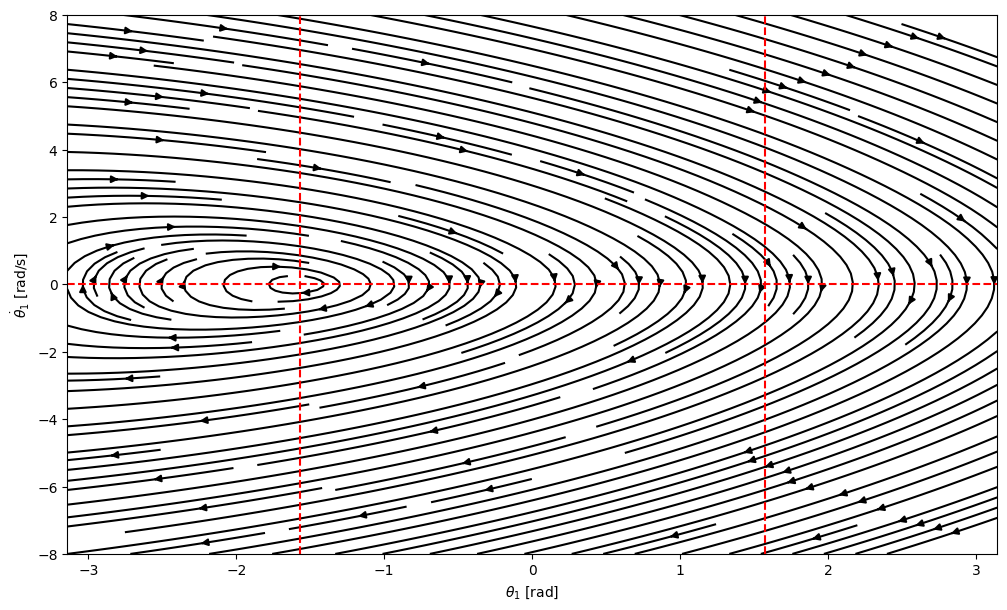

In [16]:
# model prediction
Y_pred_small_osc = forward_model_small_osc.predict(X_test)
Y_pred_mean_grid_small_osc = (
    Y_pred_small_osc[:, 0].detach().cpu().view(100, 100).numpy()
)

# plot phase portrait
fig, ax = plt.subplots(figsize=(12, 7))
ax.streamplot(
    theta_grid,
    theta_dot_grid,
    theta_dot_grid,
    Y_pred_mean_grid_small_osc,
    density=2,
    color="black",
)
ax.set_xlabel(r"$\theta_1$ [rad]")
ax.set_ylabel(r"$\dot{\theta}_1$ [rad/s]")
ax.vlines(-np.pi / 2, theta_dot_min, theta_dot_max, color="red", linestyles="dashed")
ax.vlines(np.pi / 2, theta_dot_min, theta_dot_max, color="red", linestyles="dashed")
ax.hlines(0, -np.pi, np.pi, color="red", linestyles="dashed")

## Task 3e.4 - Comparison of MPL phase portraits (1.5p)
Compare the two phase portraits you created in this notebook (i.e., Task 3e). Why are they different? 

YOUR ANSWER HERE

## Task 3e.5 - Comparison of MLP with GP phase portraits (1.5p)
Compare the two phase portraits of the MLP with the same phase portraits generated with the Gaussian Process in the previous notebook (i.e., Task 3d). How and why are they different? 

YOUR ANSWER HERE